In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import train
import network_unet as unet
import network_hed as hed
import torch

#reimport
import evaluation as eval
import importlib
importlib.reload(eval)

import utils

In [100]:
from torchvision.models import efficientnet_b0, efficientnet_b7
backbone = efficientnet_b7(pretrained=True)

# Print block names
for name, param in backbone.named_parameters():
    print(name)

/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.1.1.block.0.0.weight
features.1.1.block.0.1.weight
features.1.1.block.0.1.bias
features.1.1.block.1.fc1.weight
features.1.1.block.1.fc1.bias
features.1.1.block.1.fc2.weight
features.1.1.block.1.fc2.bias
features.1.1.block.2.0.weight
features.1.1.block.2.1.weight
features.1.1.block.2.1.bias
features.1.2.block.0.0.weight
features.1.2.block.0.1.weight
features.1.2.block.0.1.bias
features.1.2.block.1.fc1.weight
features.1.2.block.1.fc1.bias
features.1.2.block.1.fc2.weight
features.1.2.block.1.fc2.bias
features.1.2.block.2.0.weight
features.1.2.block.2.1.weight
features.1.2.block.2.1.bias
features.1.3.block.0.0.weight
features.1.3

# DATA

In [6]:
# Test data
target_pos = 4

test_file = '../data/SIVE/test/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

print("Test dimensions:")
print(np.shape(test_targets))
print(np.shape(test_input))

Test dimensions:
(196, 144, 144)
(196, 4, 144, 144)


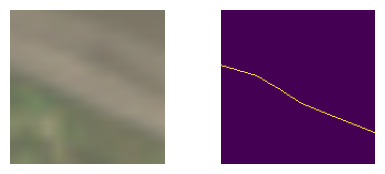

In [3]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

fig, ax = plt.subplots(1,2,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)

for a in ax:
    a.axis('off')

# HED

Using device: mps

196
accuracy: 99.4274
precision: 0.0
recall: 0.0
f1: 0.0
iou: nan
fom: 0.0


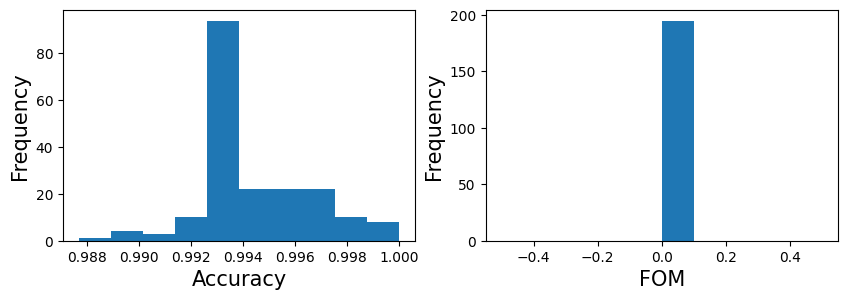

In [75]:
model_name = "SIVE_01MAR2025_HED_BCE.pth"
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

backbone = hed.SimpleCNNBackbone(in_channels=4)
model = hed.HED(backbone=backbone, out_channels=1)

state_dict = torch.load(f'../models/{model_name}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))

test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)
eval.display_metrics(test_metrics, test_arr)

[0.]


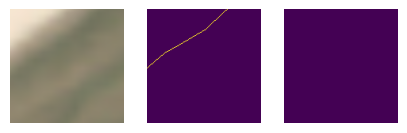

In [94]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

pred = test_preds[i]
print(np.unique(pred))

fig, ax = plt.subplots(1,3,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

# UNET

In [105]:
model_name = "SIVE_30APR2025_UNET_DICE.pth"
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

model = unet.U_Net(4, 1)

state_dict = torch.load(f'../models/{model_name}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

In [106]:
targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))

196


[0.]


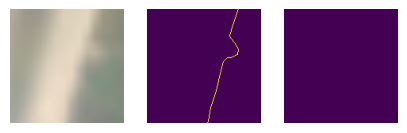

In [155]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

pred = test_preds[i]
print(np.unique(pred))

fig, ax = plt.subplots(1,3,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

accuracy: 98.5036
precision: 14.3917
recall: 40.3662
f1: 20.2995
iou: nan
fom: 63.5915


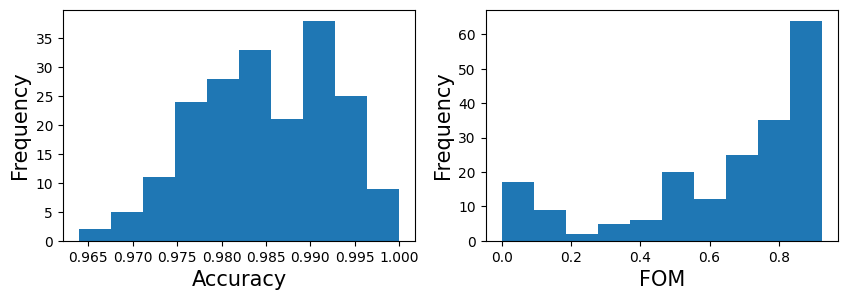

In [158]:
importlib.reload(eval)
test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)
eval.display_metrics(test_metrics, test_arr)